# What does an customer default with Afterpay look like ?
> Let's take a high level view of what an aveage default looks like, based on Afterpay's FY2019 Annual report.

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,Finance]
    
- image: images/2020-08-21-Afterpay-Customer-Defaults-Part-1/header.jpg

## Introduction

From the [previous post](https://cgcooke.github.io/Blog/bayesian/finance/2020/08/21/Afterpay-Customer-Defaults-Part-1.html), I made some high level estimates for how often *Afterpay* transactions attracted late fees. If we could better understand the real distribution of late fees, then we could in turn better estimate the frequency of late fees.


> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.


## What do we know?

* Late Fees Revenue : 46.1 million AUD
* Average Transaction Value : Approximately 150 AUD
   
Furthermore, we know that the lowest and highest fee that you can be charged for a single transaction is 10 AUD and 68 AUD. Hence, this in turn bounds the average of the late fees.


*Afterpay* is pretty transparent about their late fees, I've taken the following from [here](https://www.afterpay.com/en-AU/terms-of-service#:~:text=If%20a%20payment%20is%20not,may%20be%20applied%20per%20order.).

![Afterpay late fees policy](../images/2020-08-22-Afterpay-Customer-Defaults-Part-2/late_fees.png)


We can model this policy out in code, keeping in mind that the customer pays *Afterpay* 4 separate times.

There are some pieces of information that we are missing.

1. The distribution of values for transactions where customers pay late.
2. How late they make each payment.

It's at this stage, we have to accept that we probably can't find an exact solution, but we can settle for a good approximation.

On assumption we could make is that the number of late payments is uncorrelated with the transaction value, and is uniformly distributed, both for delays of less than, and more than 1 week.

## Computing late fees

In [1]:
import random

def compute_late_fee(transaction_value,probability_of_late_payment = 0.5):
    total_fees = 0
    
    number_of_delays_of_less_than_1_week = 1 + np.random.binomial(3,probability_of_late_payment,1)[0]
    
    if number_of_delays_of_less_than_1_week > 0:
        number_of_delays_of_more_than_1_week = np.random.binomial(number_of_delays_of_less_than_1_week,probability_of_late_payment,1)[0]
    
    total_fees = 10 * number_of_delays_of_less_than_1_week + 7 * number_of_delays_of_more_than_1_week
    late_fee = min([total_fees,0.25*transaction_value])
    late_fee = max([late_fee,10])
    return(late_fee)


In [2]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

## Modelling transaction values

Let's model the transaction values. 

I'm making two assumption:

1. Transactions where the customer is late in paying, have the same average transaction value as other payments.
2. Transaction values are Exponentially distributed.

In [3]:
with pm.Model() as model:
    average_transaction_value_aud = pm.Uniform('average_transaction_value_aud', lower=144.50, upper=154.49)
    transaction_value_aud = pm.Bound(pm.Exponential, upper=1_500.0)('transaction_value_aud', lam = 1/average_transaction_value_aud)

Now that we have instantiated all of the random variables, we will take 50,000 draws from them, in order to perform our *Monte carlo* simulation.

In [4]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=50_000, random_seed=0)

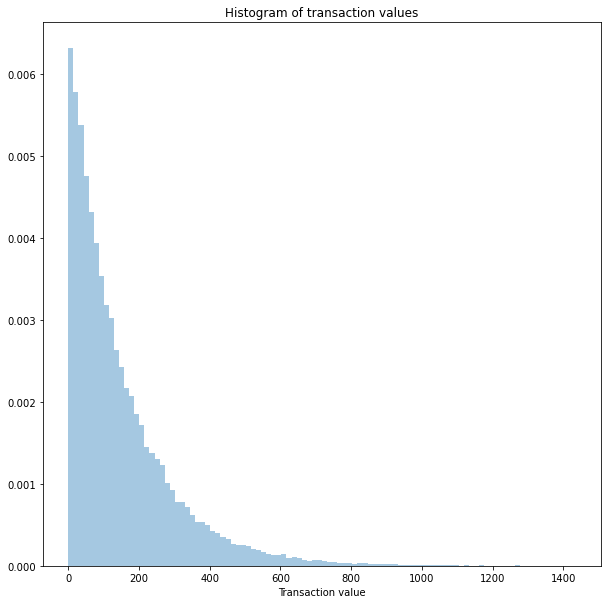

In [5]:
sns.distplot(prior_checks["transaction_value_aud"], kde=False, norm_hist=True, bins=100)
plt.title('Histogram of transaction values')
plt.xlabel('Transaction value')
plt.show()

As we can see, this distribution has a mean of approximately 150 AUD.

In [6]:
pm.summary(prior_checks['transaction_value_aud'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,150.103,150.269,0.0,422.672,0.675,0.477,49547.0,49547.0,49322.0,49878.0,NaN


## Modelling late fees

In [7]:
late_fees = []
for transaction_value in prior_checks["transaction_value_aud"]:
    late_fee = compute_late_fee(transaction_value)
    late_fees.append(late_fee)
late_fees = np.array(late_fees)

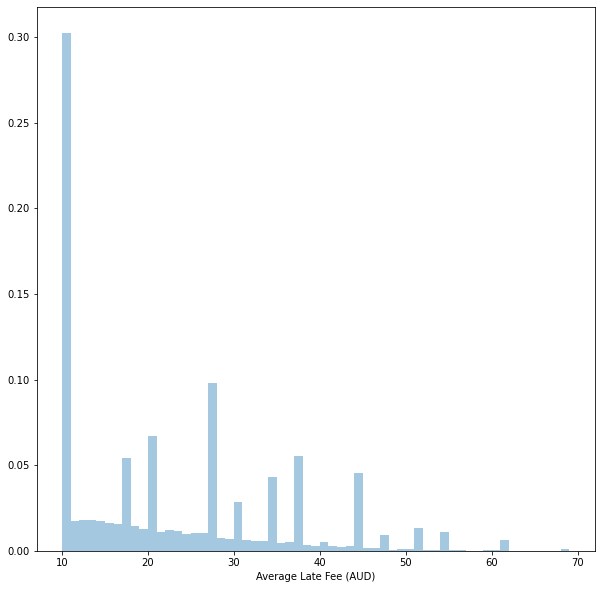

In [8]:
sns.distplot(late_fees, kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.xlabel('Average Late Fee (AUD)')
plt.show()

In [9]:
pm.summary(late_fees)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,22.585,12.514,10.0,44.0,0.056,0.04,49161.0,49161.0,48824.0,49670.0,NaN


## Conclusion

We now have the ability to compute the expected average late fee, given a distribution of transaction values, and a probability of making each payment on time.  In our case, we found the average late fee was 37.49 AUD. 

However, I don't think we can really conclude anything meaningful, from just a single distribution of transaction values and a single probability of making each payment on time. 

Given this, we can try lots of different distributions, and use this to find the distribution of average late fees that we could see. Next post, I will make the way I do the sampling more computationally efficient. This will allow us to draw some meaningful conclusions. 



